# Heart Failure Prediction using Neural Networks

Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worldwide. Four out of 5CVD deaths are due to heart attacks and strokes, and one-third of these deaths occur prematurely in people under 70 years of age. Heart failure is a common event caused by CVDs and this dataset contains 11 features that can be used to predict a possible heart disease.

People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.

In this notebook, a vanilla neural network with rectified units (ReLU) will be used to classify whether a certain individual is likely at risk of heart failure given attribute and health background information.

## 0. Imports & Hyperparameters

In [1]:
# Necessary Imports
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler

# Set random seed for deterministic random values (42 is just a common number to set)
torch.manual_seed(42)

# Hyperparameters
LEARNING_RATE = 0.001
EPOCHS = 10
HIDDEN_SIZE = 128
TRAIN_TEST_SPLIT = 0.80
BATCH_SIZE = 64
PLOT_STEPS = 1
PRINT_STEPS = 1

# Check PyTorch version
torch.__version__

'2.5.1+cpu'

## 1. Data Processing

In [2]:
df = pd.read_csv('data/heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
scaler = MinMaxScaler() # Normalize values for faster model training

num_cols = list(df.select_dtypes('number').columns)[:-1] # We do not want to touch the target column
df[num_cols] = scaler.fit_transform(df[num_cols])

df = pd.get_dummies(df, dtype='int') # One-hot encoding

df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,0.244898,0.70,0.479270,0.0,0.788732,0.295455,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
1,0.428571,0.80,0.298507,0.0,0.676056,0.409091,1,1,0,0,...,1,0,0,1,0,1,0,0,1,0
2,0.183673,0.65,0.469320,0.0,0.267606,0.295455,0,0,1,0,...,0,0,0,0,1,1,0,0,0,1
3,0.408163,0.69,0.354892,0.0,0.338028,0.465909,1,1,0,1,...,0,0,0,1,0,0,1,0,1,0
4,0.530612,0.75,0.323383,0.0,0.436620,0.295455,0,0,1,0,...,1,0,0,1,0,1,0,0,0,1


In [4]:
# First convert pandas DataFrame to numpy, and then later convert to PyTorch tensor
df_numpy = df.to_numpy()
df_numpy

array([[0.24489796, 0.7       , 0.47927032, ..., 0.        , 0.        ,
        1.        ],
       [0.42857143, 0.8       , 0.29850746, ..., 0.        , 1.        ,
        0.        ],
       [0.18367347, 0.65      , 0.46932007, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.59183673, 0.65      , 0.2172471 , ..., 0.        , 1.        ,
        0.        ],
       [0.59183673, 0.65      , 0.39137645, ..., 0.        , 1.        ,
        0.        ],
       [0.20408163, 0.69      , 0.29021559, ..., 0.        , 0.        ,
        1.        ]])

In [5]:
df_numpy.shape

(918, 21)

In [6]:
# The last column will act as the target vector, while the rest of the rows and columns are the input matrix
X = torch.tensor(df_numpy[:, :-1], dtype=torch.float32)
y = torch.tensor(df_numpy[:, -1], dtype=torch.float32)

X.shape, y.shape

(torch.Size([918, 20]), torch.Size([918]))

In [7]:
# Get training and testing date
cutoff_idx = int(len(X) * TRAIN_TEST_SPLIT)

X_train, X_test = X[:cutoff_idx], X[cutoff_idx:]
y_train, y_test = y[:cutoff_idx], y[cutoff_idx:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([734, 20]),
 torch.Size([734]),
 torch.Size([184, 20]),
 torch.Size([184]))

In [8]:
# Create training and testing dataset

class HeartFailureDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        assert(len(self.X) == len(self.y))
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = HeartFailureDataset(X_train, y_train)
test_dataset = HeartFailureDataset(X_test, y_test)

len(train_dataset), len(test_dataset)

(734, 184)

In [9]:
# Create train and test dataloaders for training with batches

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# See how many batches we have
len(train_dataloader), len(test_dataloader)

(12, 3)

## 2. Building Neural Network

In [10]:
"""
Build a vanilla dense (fully-connected) neural network with rectified units

Batch normalization is also implemented to normalize data to make training faster.

Furthermore, dropout is implemented in case to mitigate the posibility of overfitting training data
"""
class HeartFailureModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super().__init__()

        self.classifier = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(hidden_size, hidden_size),

            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(hidden_size, hidden_size),

            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.classifier(x)


model = HeartFailureModel(
    input_size=20, # The number of columns in the input matrix (X) after performing one-hot encoding during data processing
    output_size=1, # This is just a binary classification problem, so the output is of shape 1
    hidden_size=HIDDEN_SIZE
)

model

HeartFailureModel(
  (classifier): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): Linear(in_features=128, out_features=128, bias=True)
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Dropout(p=0.2, inplace=False)
    (13): Linear(in_features=128, out_features=128, bias=True)
    (14): Linear(in_features=128, out_features=128, bias=True)
    (15): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): ReLU()
    (17): Dropout(p=0.2, inplace=F

## 3. Training & Testing Model

In [11]:
# Loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=LEARNING_RATE
)

In [12]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# Model training procedure
def train(model, dataloader, loss_fn, optimizer):
    cur_loss, cur_acc = 0.0, 0.0
    model.train()

    for X, y in dataloader:
        logits = model(X).squeeze()

        # Remember that BCEWithLogits expected raw logits, so sigmoid function unnecessary
        loss = loss_fn(logits, y)
        cur_loss += loss.item()

        # When calculating accuracy, however, sigmoid function is needed to output actual predictive values
        pred = torch.round(torch.sigmoid(logits))
        acc = accuracy_fn(y_true=y, y_pred=pred)
        cur_acc += acc

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    cur_loss /= len(dataloader)
    cur_acc /= len(dataloader)
    
    return cur_loss, cur_acc

# Model testing procedure
def test(model, dataloader, loss_fn, optimizer):
    cur_loss, cur_acc = 0.0, 0.0
    model.eval()

    with torch.inference_mode():
        for X, y in dataloader:
            logits = model(X).squeeze()

            loss = loss_fn(logits, y)
            cur_loss += loss.item()

            pred = torch.round(torch.sigmoid(logits))
            acc = accuracy_fn(y_true=y, y_pred=pred)
            cur_acc += acc

        cur_loss /= len(dataloader)
        cur_acc /= len(dataloader)

    return cur_loss, cur_acc

In [13]:
# Store loss and accuracy for model evaluation
all_train_losses, all_test_losses = [], []
all_train_acc, all_test_acc = [], []

# Calculate running loss and accuracy during training
running_train_loss, running_test_loss = 0.0, 0.0
running_train_acc, running_test_acc = 0.0, 0.0

# Training and testing loop
for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_dataloader, loss_fn, optimizer)
    test_loss, test_acc = test(model, test_dataloader, loss_fn, optimizer)

    running_train_loss += train_loss
    running_test_loss += test_loss

    running_train_acc += train_acc
    running_test_acc += test_acc

    if (epoch + 1) % PLOT_STEPS == 0:
        all_train_losses.append(running_train_loss / PLOT_STEPS)
        all_test_losses.append(running_test_loss / PLOT_STEPS)

        all_train_acc.append(running_train_acc / PLOT_STEPS)
        all_test_acc.append(running_test_acc / PLOT_STEPS)

        running_train_loss, running_test_loss = 0.0, 0.0
        running_train_acc, running_test_acc = 0.0, 0.0

    if (epoch + 1) % PRINT_STEPS == 0:
        print(f"Epoch: {epoch + 1} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Train Acc: {train_acc:.4f} | Test acc: {test_acc:.4f}")

Epoch: 1 | Train Loss: 0.3605 | Test Loss: 0.5814 | Train Acc: 86.9618 | Test acc: 92.5595
Epoch: 2 | Train Loss: 0.1121 | Test Loss: 0.1842 | Train Acc: 98.5677 | Test acc: 97.8423
Epoch: 3 | Train Loss: 0.0572 | Test Loss: 0.0513 | Train Acc: 99.7396 | Test acc: 99.4048
Epoch: 4 | Train Loss: 0.0508 | Test Loss: 0.0168 | Train Acc: 99.4618 | Test acc: 100.0000
Epoch: 5 | Train Loss: 0.0203 | Test Loss: 0.0114 | Train Acc: 100.0000 | Test acc: 100.0000
Epoch: 6 | Train Loss: 0.0193 | Test Loss: 0.0094 | Train Acc: 99.8698 | Test acc: 100.0000
Epoch: 7 | Train Loss: 0.0135 | Test Loss: 0.0075 | Train Acc: 100.0000 | Test acc: 100.0000
Epoch: 8 | Train Loss: 0.0095 | Test Loss: 0.0065 | Train Acc: 100.0000 | Test acc: 100.0000
Epoch: 9 | Train Loss: 0.0103 | Test Loss: 0.0051 | Train Acc: 99.8698 | Test acc: 100.0000
Epoch: 10 | Train Loss: 0.0173 | Test Loss: 0.0047 | Train Acc: 99.3316 | Test acc: 100.0000


100% Accuracy :)

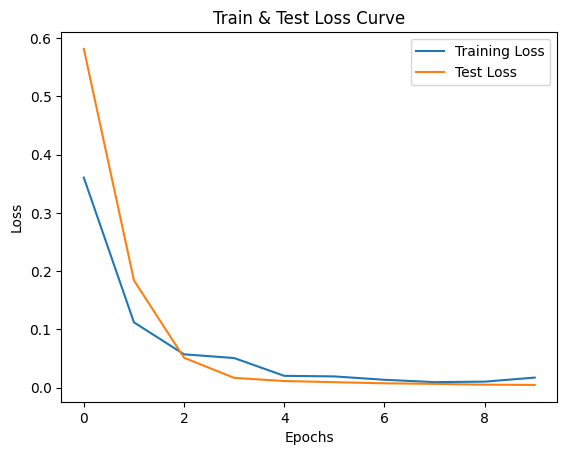

In [14]:
# Plot train and test loss
plt.title("Train & Test Loss Curve")
plt.plot(all_train_losses)
plt.plot(all_test_losses)
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss');

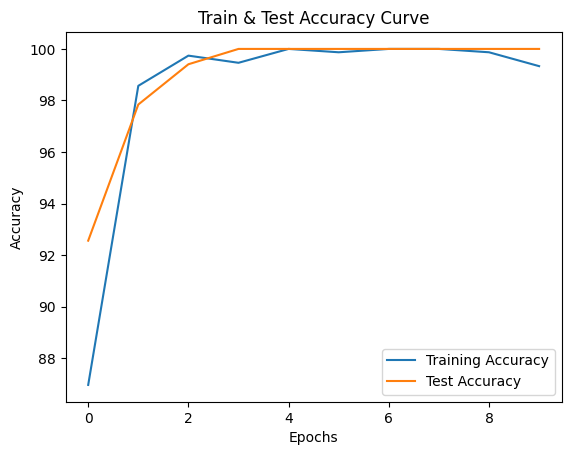

In [15]:
# Plot train and test accuracy
plt.title("Train & Test Accuracy Curve")
plt.plot(all_train_acc)
plt.plot(all_test_acc)
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy');